## Intro

In [1]:
!nvidia-smi
!cat /proc/meminfo
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Wed Aug 10 16:57:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6978591647156676414
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14444920832
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5545775027336014930
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [2]:
colab = True

if colab == True:
  from google.colab import drive
  drive.mount('/content/drive')

  from os import listdir
  from os.path import isfile, join
  print (listdir('/content/drive/MyDrive/CNN_Knee/padrao_ouro_pr/Stratified_2/1/train'))

Mounted at /content/drive
['0', '1', '.DS_Store']


## Evaluating (Otimizacao de Threshold) - dois folds juntos

In [3]:
import torchvision.models as models
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import pandas as pd
import scipy.stats as st

In [4]:
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


In [5]:
def metrics(y_pred, y_real, thresholds=np.linspace(0, 1, 100)):   
    SENS = []
    ESP = []
    ACU = []
    THRES = []
    PREC = []
    F1 = []
    B_ACU = []
    max_acc = 0
    max_acc_sens = 0
    max_acc_esp = 0 
    #print(y_pred, y_real)
    for thres in thresholds:
        TN, FP, FN, TP = confusion_matrix(y_real, y_pred>thres).ravel()
        esp = TN/(TN+FP)
        sens = TP/(TP+FN)
        acc = (TP+TN)/(TP+TN+FP+FN)
        prec = TP/(TP+FP)
        f1 = 2*(prec*sens)/(prec+sens)
        b_acu = (sens+esp)/2
        SENS.append(sens)
        ESP.append(esp)
        ACU.append(acc)
        B_ACU.append(b_acu)
        THRES.append(thres)
        PREC.append(prec)
        F1.append(f1)
    df_metrics = pd.DataFrame([THRES, SENS, ESP, ACU, B_ACU, PREC, F1]).T
    df_metrics.columns = ['Threshold', 'Sensitivity', 'Specificity', 'Accuracy', 'Balanced Accuracy', 'Precision', 'F1']
    return(df_metrics)

## Set transformations

In [9]:
#Transformations (from images to tensor)
transformations = transforms.Compose([
    #transforms.Grayscale(num_output_channels=1), 
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.4961825801749269, 0.24619624513349647)
])

## Custom Loss - Fold 1

In [7]:
#Load data

N_FOLDS = '2'
FOLD = '1'

COLAB = True
DAUG_PLUS = False
N_GPUS = 1
CUSTOM_LOSS = False
WEIGHT_CLASS_0 = 1.0
WEIGHT_CLASS_1 = 10.0

# -1 if first run (epoch == 0)
LAST_EPOCH = -1

if COLAB == True:
  val_set = datasets.ImageFolder(f'/content/drive/MyDrive/CNN_Knee/padrao_ouro_pr/Stratified_{N_FOLDS}/{FOLD}/test', transform = transformations)
else:
  val_set = datasets.ImageFolder(f"padrao_ouro_pr/Stratified/4/test", transform = transformations)

# Put into a Dataloader using torch library
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True)

# Find the device available to use using torch library
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Se for somente uma GPU, tirar o .module apos model (aqui, no .train e .eval)
criterion = nn.NLLLoss()

# load_epoch = range(12)
for load_epoch in range(3, 9):
    print(f'epoch {load_epoch}:')
    #model = models.densenet161(pretrained=True)
    #model = torch.load(f'kneemodel_loss{CUSTOM_LOSS}_{WEIGHT_CLASS_1}_DAug{DAUG_PLUS}_Strat_{N_FOLDS}_f{FOLD}_e{load_epoch}_JULIO.pth')
    model = torch.load(f'/content/drive/MyDrive/CNN_Knee/kneemodels_julio/std_loss/kneemodel_Strat_{N_FOLDS}_{FOLD}_{load_epoch}_JULIO.pth')
    # Move model to the device specified above
    model.to(device)

    FP = 0
    FN = 0
    TP = 0
    TN = 0
    Y_PRED = []
    Y1 = []
    counter = 0

    vetor_auc_1 = []

    model.eval()
    for inputs, labels in val_loader:
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass
        output = model.forward(inputs)
        # Calculate Loss
        valloss = criterion(output, labels)
        # Add loss to the validation set's running loss
        val_loss = valloss.item()*inputs.size(0)

        # Since our model outputs a LogSoftmax, find the real 
        # percentages by reversing the log function
        output = torch.exp(output)
        y_pred_batch = [el[1] for el in output.cpu().detach().numpy()]
        Y_PRED.append(output.cpu().detach().numpy())
        # Get the top class of the output
        top_p, top_class = output.topk(1, dim=1)
        # See how many of the classes were correct?
        equals = top_class == labels.view(*top_class.shape)
        # Calculate the mean (get the accuracy for this batch)
        # and add it to the running accuracy for this epoch
        accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
        y = labels.cpu().numpy()
        Y1.append(y)
        y_pred = np.concatenate(top_class.cpu().numpy())
        for i, label in enumerate(y):
            if y[i] == 0:
                if y_pred[i] == 0:
                    TN += 1
                elif y_pred[i] == 1:
                    FP += 1
            elif y[i] == 1:
                if y_pred[i] == 1:
                    TP += 1
                elif y_pred[i] == 0:
                    FN += 1

        counter += 1
        
        auc_batch_1 = roc_auc_score(y, y_pred_batch)

        vetor_auc_1.append(auc_batch_1)

        #print(counter, "/", len(val_loader), end=" ")
        print(counter, end=" ")
    print("/", len(val_loader))

    Y_PRED_1 = []
    for batch in Y_PRED:
        for arr in batch:
            Y_PRED_1.append(arr[1])
    Y1 = np.concatenate(Y1)

    #Performance
    acu = (TP+TN)/(TP+TN+FP+FN)
    sen = TP/(TP+FN)
    esp = TN/(TN+FP)
    prec = TP/(TP+FP)
    f1 = 2*(sen * prec) / (sen + prec)
    auc_epoch_1 = roc_auc_score(Y1, Y_PRED_1)

    # Calcular IC para a AUC
    ci = st.t.interval(0.95, len(vetor_auc_1)-1, loc=np.mean(vetor_auc_1), scale=st.sem(vetor_auc_1))

    print('Acuracia: ', acu)
    print('Sensibilidade: ', sen)
    print('Especificidade: ', esp)
    print('Precisao: ', prec)
    print('F1: ', f1)
    print('AUC: ', auc_epoch_1)
    #print('vetor do IC de AUC', vetor_auc_1)
    print('IC 95% da AUC:', ci)

cuda
epoch 3:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 / 22
Acuracia:  0.9044655929721815
Sensibilidade:  0.23417721518987342
Especificidade:  0.992135761589404
Precisao:  0.7956989247311828
F1:  0.36185819070904646
AUC:  0.8774749297929415
IC 95% da AUC: (0.8481477217338158, 0.9013883267948388)
epoch 4:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 / 22
Acuracia:  0.9095900439238653
Sensibilidade:  0.4272151898734177
Especificidade:  0.972682119205298
Precisao:  0.6716417910447762
F1:  0.5222437137330755
AUC:  0.8797815460222985
IC 95% da AUC: (0.8563601627184951, 0.905540911274308)
epoch 5:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 / 22
Acuracia:  0.9110541727672035
Sensibilidade:  0.44936708860759494
Especificidade:  0.9714403973509934
Precisao:  0.6729857819905213
F1:  0.5388994307400379
AUC:  0.8788869299606001
IC 95% da AUC: (0.8551150382887541, 0.8984907696047814)
epoch 6:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 / 22
Acu

### Selecionar a época de maior AUC - Fold 1

In [10]:
#Load data

N_FOLDS = '2'
FOLD = '1'

COLAB = True
DAUG_PLUS = False
N_GPUS = 1
CUSTOM_LOSS = False
WEIGHT_CLASS_0 = 1.0
WEIGHT_CLASS_1 = 10.0

# -1 if first run (epoch == 0)
LAST_EPOCH = -1

if COLAB == True:
  val_set = datasets.ImageFolder(f'/content/drive/MyDrive/CNN_Knee/padrao_ouro_pr/Stratified_{N_FOLDS}/{FOLD}/test', transform = transformations)
else:
  val_set = datasets.ImageFolder(f"padrao_ouro_pr/Stratified/4/test", transform = transformations)

# Put into a Dataloader using torch library
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True)

# Find the device available to use using torch library
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Se for somente uma GPU, tirar o .module apos model (aqui, no .train e .eval)
criterion = nn.NLLLoss()

load_epoch = 6
print(f'epoch {load_epoch}:')
#model = models.densenet161(pretrained=True)
#model = torch.load(f'kneemodel_loss{CUSTOM_LOSS}_{WEIGHT_CLASS_1}_DAug{DAUG_PLUS}_Strat_{N_FOLDS}_f{FOLD}_e{load_epoch}_JULIO.pth')
model = torch.load(f'/content/drive/MyDrive/CNN_Knee/kneemodels_julio/std_loss/kneemodel_Strat_{N_FOLDS}_{FOLD}_{load_epoch}_JULIO.pth')
# Move model to the device specified above
model.to(device)

FP = 0
FN = 0
TP = 0
TN = 0
Y_PRED = []
Y1 = []
counter = 0

vetor_acc_1 = []
vetor_sen_1 = []
vetor_esp_1 = []
vetor_f1_1 = []
vetor_prec_1 = []
vetor_auc_1 = []

model.eval()
for inputs, labels in val_loader:
    # Move to device
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    output = model.forward(inputs)
    # Calculate Loss
    valloss = criterion(output, labels)
    # Add loss to the validation set's running loss
    val_loss = valloss.item()*inputs.size(0)

    # Since our model outputs a LogSoftmax, find the real 
    # percentages by reversing the log function
    output = torch.exp(output)
    y_pred_batch = [el[1] for el in output.cpu().detach().numpy()]
    Y_PRED.append(output.cpu().detach().numpy())
    # Get the top class of the output
    top_p, top_class = output.topk(1, dim=1)
    # See how many of the classes were correct?
    equals = top_class == labels.view(*top_class.shape)
    # Calculate the mean (get the accuracy for this batch)
    # and add it to the running accuracy for this epoch
    accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
    y = labels.cpu().numpy()
    Y1.append(y)
    y_pred = np.concatenate(top_class.cpu().numpy())
    for i, label in enumerate(y):
        if y[i] == 0:
            if y_pred[i] == 0:
                TN += 1
            elif y_pred[i] == 1:
                FP += 1
        elif y[i] == 1:
            if y_pred[i] == 1:
                TP += 1
            elif y_pred[i] == 0:
                FN += 1

    counter += 1
    
    auc_batch_1 = roc_auc_score(y, y_pred_batch)

    vetor_auc_1.append(auc_batch_1)

    #print(counter, "/", len(val_loader), end=" ")
    print(counter, end=" ")
print("/", len(val_loader))

Y_PRED_1 = []
for batch in Y_PRED:
    for arr in batch:
        Y_PRED_1.append(arr[1])
Y1 = np.concatenate(Y1)

#Performance
acu = (TP+TN)/(TP+TN+FP+FN)
sen = TP/(TP+FN)
esp = TN/(TN+FP)
prec = TP/(TP+FP)
f1 = 2*(sen * prec) / (sen + prec)
auc_epoch_1 = roc_auc_score(Y1, Y_PRED_1)

# Calcular IC para a AUC
ci = st.t.interval(0.95, len(vetor_auc_1)-1, loc=np.mean(vetor_auc_1), scale=st.sem(vetor_auc_1))

print('Acuracia: ', acu)
print('Sensibilidade: ', sen)
print('Especificidade: ', esp)
print('Precisao: ', prec)
print('F1: ', f1)
print('AUC: ', auc_epoch_1)
#print('vetor do IC de AUC', vetor_auc_1)
print('IC 95% da AUC:', ci)

cuda
epoch 6:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 / 22
Acuracia:  0.9128843338213762
Sensibilidade:  0.4525316455696203
Especificidade:  0.9730960264900662
Precisao:  0.6875
F1:  0.5458015267175573
AUC:  0.8806460359208651
IC 95% da AUC: (0.8548795461327052, 0.902477172607552)


#### Estimativas - Fold 1

In [9]:
df_metrics = metrics(Y_PRED_1, Y1, thresholds=np.linspace(0, 1, 200))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


In [10]:
df_metrics.loc[df_metrics['Balanced Accuracy']==max(df_metrics['Balanced Accuracy'])]

,Threshold,Sensitivity,Specificity,Accuracy,Balanced Accuracy,Precision,F1
20,0.100503,0.759494,0.841887,0.832357,0.800691,0.385852,0.511727


In [11]:
df_metrics.loc[(df_metrics['Sensitivity']>0.9) & (df_metrics['Specificity']>0)]

,Threshold,Sensitivity,Specificity,Accuracy,Balanced Accuracy,Precision,F1
1,0.005025,0.981013,0.225166,0.312592,0.603089,0.142071,0.248199
2,0.010050,0.968354,0.358858,0.429356,0.663606,0.164960,0.281898
3,0.015075,0.949367,0.453228,0.510615,0.701298,0.185071,0.309757
4,0.020101,0.939873,0.517798,0.566618,0.728836,0.203146,0.334083
5,0.025126,0.917722,0.572848,0.612738,0.745285,0.219365,0.354090
6,0.030151,0.905063,0.622517,0.655198,0.763790,0.238731,0.377807


In [12]:
#Ponto maximo de F1
df_metrics.loc[df_metrics['F1']==max(df_metrics['F1'])]

,Threshold,Sensitivity,Specificity,Accuracy,Balanced Accuracy,Precision,F1
63,0.316583,0.585443,0.946606,0.904832,0.766024,0.589172,0.587302


In [13]:
#Ponto maximo de Balanced Accuracy
df_metrics.loc[df_metrics['Balanced Accuracy']==max(df_metrics['Balanced Accuracy'])]

,Threshold,Sensitivity,Specificity,Accuracy,Balanced Accuracy,Precision,F1
20,0.100503,0.759494,0.841887,0.832357,0.800691,0.385852,0.511727


In [14]:
#Maiores sensibilidades, mantendo Spec > 0.4
df_metrics.loc[(df_metrics['Sensitivity']>0.9) & (df_metrics['Specificity']>0.4)]

,Threshold,Sensitivity,Specificity,Accuracy,Balanced Accuracy,Precision,F1
3,0.015075,0.949367,0.453228,0.510615,0.701298,0.185071,0.309757
4,0.020101,0.939873,0.517798,0.566618,0.728836,0.203146,0.334083
5,0.025126,0.917722,0.572848,0.612738,0.745285,0.219365,0.354090
6,0.030151,0.905063,0.622517,0.655198,0.763790,0.238731,0.377807


In [15]:
#Maior acuracia
df_metrics.loc[df_metrics['Accuracy']==max(df_metrics['Accuracy'])]

,Threshold,Sensitivity,Specificity,Accuracy,Balanced Accuracy,Precision,F1
99,0.497487,0.452532,0.973096,0.912884,0.712814,0.6875,0.545802
100,0.502513,0.452532,0.973096,0.912884,0.712814,0.6875,0.545802


## Custom Loss - Fold 2

In [16]:
#Load data

N_FOLDS = '2'
FOLD = '2'

COLAB = True
DAUG_PLUS = False
N_GPUS = 1
CUSTOM_LOSS = False
WEIGHT_CLASS_0 = 1.0
WEIGHT_CLASS_1 = 10.0

# -1 if first run (epoch == 0)
LAST_EPOCH = -1

if COLAB == True:
  val_set = datasets.ImageFolder(f'/content/drive/MyDrive/CNN_Knee/padrao_ouro_pr/Stratified_{N_FOLDS}/{FOLD}/test', transform = transformations)
else:
  val_set = datasets.ImageFolder(f"padrao_ouro_pr/Stratified/4/test", transform = transformations)

# Put into a Dataloader using torch library
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True)

# Find the device available to use using torch library
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Se for somente uma GPU, tirar o .module apos model (aqui, no .train e .eval)
criterion = nn.NLLLoss()

# load_epoch = range(12)
for load_epoch in range(3, 8):
    print(f'epoch {load_epoch}:')
    #model = models.densenet161(pretrained=True)
    #model = torch.load(f'kneemodel_loss{CUSTOM_LOSS}_{WEIGHT_CLASS_1}_DAug{DAUG_PLUS}_Strat_{N_FOLDS}_f{FOLD}_e{load_epoch}_JULIO.pth')
    model = torch.load(f'/content/drive/MyDrive/CNN_Knee/kneemodels_julio/std_loss/kneemodel_loss{CUSTOM_LOSS}_{WEIGHT_CLASS_1}_DAug{DAUG_PLUS}_Strat_{N_FOLDS}_f{FOLD}_e{load_epoch}_JULIO.pth')
    # Move model to the device specified above
    model.to(device)

    FP = 0
    FN = 0
    TP = 0
    TN = 0
    Y_PRED = []
    Y2 = []
    counter = 0

    vetor_auc_2 = []

    model.eval()
    for inputs, labels in val_loader:
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass
        output = model.forward(inputs)
        # Calculate Loss
        valloss = criterion(output, labels)
        # Add loss to the validation set's running loss
        val_loss = valloss.item()*inputs.size(0)

        # Since our model outputs a LogSoftmax, find the real 
        # percentages by reversing the log function
        output = torch.exp(output)
        y_pred_batch = [el[1] for el in output.cpu().detach().numpy()]
        Y_PRED.append(output.cpu().detach().numpy())
        # Get the top class of the output
        top_p, top_class = output.topk(1, dim=1)
        # See how many of the classes were correct?
        equals = top_class == labels.view(*top_class.shape)
        # Calculate the mean (get the accuracy for this batch)
        # and add it to the running accuracy for this epoch
        accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
        y = labels.cpu().numpy()
        Y2.append(y)
        y_pred = np.concatenate(top_class.cpu().numpy())
        for i, label in enumerate(y):
            if y[i] == 0:
                if y_pred[i] == 0:
                    TN += 1
                elif y_pred[i] == 1:
                    FP += 1
            elif y[i] == 1:
                if y_pred[i] == 1:
                    TP += 1
                elif y_pred[i] == 0:
                    FN += 1

        counter += 1
        
        auc_batch_2 = roc_auc_score(y, y_pred_batch)

        vetor_auc_2.append(auc_batch_2)

        #print(counter, "/", len(val_loader), end=" ")
        print(counter, end=" ")
    print("/", len(val_loader))

    Y_PRED_2 = []
    for batch in Y_PRED:
        for arr in batch:
            Y_PRED_2.append(arr[1])
    Y2 = np.concatenate(Y2)

    #Performance
    acu = (TP+TN)/(TP+TN+FP+FN)
    sen = TP/(TP+FN)
    esp = TN/(TN+FP)
    prec = TP/(TP+FP)
    f1 = 2*(sen * prec) / (sen + prec)
    auc_epoch_2 = roc_auc_score(Y2, Y_PRED_2)

    # Calcular IC para a AUC
    ci = st.t.interval(0.95, len(vetor_auc_2)-1, loc=np.mean(vetor_auc_2), scale=st.sem(vetor_auc_2))

    print('Acuracia: ', acu)
    print('Sensibilidade: ', sen)
    print('Especificidade: ', esp)
    print('Precisao: ', prec)
    print('F1: ', f1)
    print('AUC: ', auc_epoch_2)
    #print('vetor do IC de AUC', vetor_auc_2)
    print('IC 95% da AUC:', ci)

cuda
epoch 3:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 / 22
Acuracia:  0.9005120702267739
Sensibilidade:  0.20440251572327045
Especificidade:  0.992135761589404
Precisao:  0.7738095238095238
F1:  0.32338308457711445
AUC:  0.8548656233079261
IC 95% da AUC: (0.8272291261025192, 0.8802930975892768)
epoch 4:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 / 22
Acuracia:  0.9074615947329919
Sensibilidade:  0.34591194968553457
Especificidade:  0.9813741721854304
Precisao:  0.7096774193548387
F1:  0.46511627906976744
AUC:  0.8575404015160981
IC 95% da AUC: (0.8383964643569305, 0.8946462623086889)
epoch 5:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 / 22
Acuracia:  0.8928310168251646
Sensibilidade:  0.5
Especificidade:  0.9445364238410596
Precisao:  0.5426621160409556
F1:  0.5204582651391162
AUC:  0.8554148964971471
IC 95% da AUC: (0.8379969950228183, 0.8780971265287987)
epoch 6:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 / 22
Acuracia:  0.88

### Selecionar a época de maior AUC - Fold 2

In [11]:
#Load data

N_FOLDS = '2'
FOLD = '2'

COLAB = True
DAUG_PLUS = False
N_GPUS = 1
CUSTOM_LOSS = False
WEIGHT_CLASS_0 = 1.0
WEIGHT_CLASS_1 = 10.0

# -1 if first run (epoch == 0)
LAST_EPOCH = -1

if COLAB == True:
  val_set = datasets.ImageFolder(f'/content/drive/MyDrive/CNN_Knee/padrao_ouro_pr/Stratified_{N_FOLDS}/{FOLD}/test', transform = transformations)
else:
  val_set = datasets.ImageFolder(f"padrao_ouro_pr/Stratified/4/test", transform = transformations)

# Put into a Dataloader using torch library
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True)

# Find the device available to use using torch library
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Se for somente uma GPU, tirar o .module apos model (aqui, no .train e .eval)
criterion = nn.NLLLoss()

load_epoch = 6
print(f'epoch {load_epoch}:')
#model = models.densenet161(pretrained=True)
#model = torch.load(f'kneemodel_loss{CUSTOM_LOSS}_{WEIGHT_CLASS_1}_DAug{DAUG_PLUS}_Strat_{N_FOLDS}_f{FOLD}_e{load_epoch}_JULIO.pth')
model = torch.load(f'/content/drive/MyDrive/CNN_Knee/kneemodels_julio/std_loss/kneemodel_loss{CUSTOM_LOSS}_{WEIGHT_CLASS_1}_DAug{DAUG_PLUS}_Strat_{N_FOLDS}_f{FOLD}_e{load_epoch}_JULIO.pth')
# Move model to the device specified above
model.to(device)

FP = 0
FN = 0
TP = 0
TN = 0
Y_PRED = []
Y2 = []
counter = 0

vetor_acc_2 = []
vetor_sen_2 = []
vetor_esp_2 = []
vetor_f1_2 = []
vetor_prec_2 = []
vetor_auc_2 = []

model.eval()
for inputs, labels in val_loader:
    # Move to device
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    output = model.forward(inputs)
    # Calculate Loss
    valloss = criterion(output, labels)
    # Add loss to the validation set's running loss
    val_loss = valloss.item()*inputs.size(0)

    # Since our model outputs a LogSoftmax, find the real 
    # percentages by reversing the log function
    output = torch.exp(output)
    y_pred_batch = [el[1] for el in output.cpu().detach().numpy()]
    Y_PRED.append(output.cpu().detach().numpy())
    # Get the top class of the output
    top_p, top_class = output.topk(1, dim=1)
    # See how many of the classes were correct?
    equals = top_class == labels.view(*top_class.shape)
    # Calculate the mean (get the accuracy for this batch)
    # and add it to the running accuracy for this epoch
    accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
    y = labels.cpu().numpy()
    Y2.append(y)
    y_pred = np.concatenate(top_class.cpu().numpy())
    for i, label in enumerate(y):
        if y[i] == 0:
            if y_pred[i] == 0:
                TN += 1
            elif y_pred[i] == 1:
                FP += 1
        elif y[i] == 1:
            if y_pred[i] == 1:
                TP += 1
            elif y_pred[i] == 0:
                FN += 1

    counter += 1
    
    auc_batch_2 = roc_auc_score(y, y_pred_batch)

    vetor_auc_2.append(auc_batch_2)

    #print(counter, "/", len(val_loader), end=" ")
    print(counter, end=" ")
print("/", len(val_loader))

Y_PRED_2 = []
for batch in Y_PRED:
    for arr in batch:
        Y_PRED_2.append(arr[1])
Y2 = np.concatenate(Y2)

#Performance
acu = (TP+TN)/(TP+TN+FP+FN)
sen = TP/(TP+FN)
esp = TN/(TN+FP)
prec = TP/(TP+FP)
f1 = 2*(sen * prec) / (sen + prec)
auc_epoch_2 = roc_auc_score(Y2, Y_PRED_2)

# Calcular IC para a AUC
ci = st.t.interval(0.95, len(vetor_auc_2)-1, loc=np.mean(vetor_auc_2), scale=st.sem(vetor_auc_2))

print('Acuracia: ', acu)
print('Sensibilidade: ', sen)
print('Especificidade: ', esp)
print('Precisao: ', prec)
print('F1: ', f1)
print('AUC: ', auc_epoch_2)
#print('vetor do IC de AUC', vetor_auc_2)
print('IC 95% da AUC:', ci)

cuda
epoch 6:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 / 22
Acuracia:  0.8895391367959035
Sensibilidade:  0.5471698113207547
Especificidade:  0.9346026490066225
Precisao:  0.5240963855421686
F1:  0.5353846153846153
AUC:  0.8576184972302054
IC 95% da AUC: (0.8243840999535733, 0.8876108538942006)


#### Estimativas - Fold 2

In [18]:
df_metrics = metrics(Y_PRED_2, Y2, thresholds=np.linspace(0, 1, 200))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


In [19]:
#Ponto maximo de F1
df_metrics.loc[df_metrics['F1']==max(df_metrics['F1'])]

,Threshold,Sensitivity,Specificity,Accuracy,Balanced Accuracy,Precision,F1
99,0.497487,0.550314,0.934189,0.889539,0.742252,0.523952,0.53681


In [20]:
#Ponto maximo de Balanced Accuracy
df_metrics.loc[df_metrics['Balanced Accuracy']==max(df_metrics['Balanced Accuracy'])]

,Threshold,Sensitivity,Specificity,Accuracy,Balanced Accuracy,Precision,F1
48,0.241206,0.738994,0.843129,0.831017,0.791061,0.382736,0.504292


In [21]:
#Maiores sensibilidades, mantendo Spec > 0.4
df_metrics.loc[(df_metrics['Sensitivity']>0.9) & (df_metrics['Specificity']>0.4)]

,Threshold,Sensitivity,Specificity,Accuracy,Balanced Accuracy,Precision,F1
4,0.020101,0.933962,0.400662,0.462692,0.667312,0.170201,0.287930
5,0.025126,0.927673,0.448262,0.504023,0.687967,0.181204,0.303186
6,0.030151,0.924528,0.479719,0.531456,0.702123,0.189555,0.314607
7,0.035176,0.921384,0.505795,0.554133,0.713589,0.197041,0.324654
8,0.040201,0.915094,0.533113,0.577542,0.724103,0.205074,0.335060


In [22]:
#Maior acuracia
df_metrics.loc[df_metrics['Accuracy']==max(df_metrics['Accuracy'])]

,Threshold,Sensitivity,Specificity,Accuracy,Balanced Accuracy,Precision,F1
162,0.814070,0.345912,0.981374,0.907462,0.663643,0.709677,0.465116
163,0.819095,0.336478,0.982616,0.907462,0.659547,0.718121,0.458244


## Unindo predições

In [12]:
#PARA UNIR AMBAS PREDICOES
Y_total = np.append(Y1, Y2)
Y_PRED_total = np.append(Y_PRED_1, Y_PRED_2)

vetor_auc_total = np.append(vetor_auc_1, vetor_auc_2)
print(vetor_auc_total)
auc_total = roc_auc_score(Y_total, Y_PRED_total)
print(auc_total)
ci = st.t.interval(0.95, len(vetor_auc_total)-1, loc=np.mean(vetor_auc_total), scale=st.sem(vetor_auc_total))
print(ci)

[0.85744568 0.82890855 0.95654478 0.8515625  0.91451149 0.9779661
 0.83480826 0.85351171 0.83076923 0.86414141 0.86087768 0.86492281
 0.93125    0.88058036 0.83261494 0.77817109 0.90234375 0.93606322
 0.94985251 0.87572867 0.94526035 0.8030888  0.87428161 0.8638339
 0.83453526 0.97105509 0.89232255 0.8        0.86135693 0.8496732
 0.89830508 0.95739348 0.8003108  0.83282828 0.88076312 0.81458333
 0.91763792 0.77966102 0.86666667 0.97117794 0.88793103 0.79799107
 0.82847341 0.65116279]
0.8659284776046128
(0.8480578505975478, 0.8866179856964678)


ROC AUC=0.866


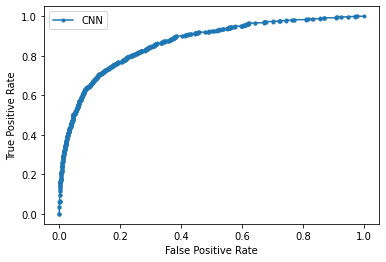

ROC AUC=0.866
Best Threshold=0.140398, G-Mean=0.788


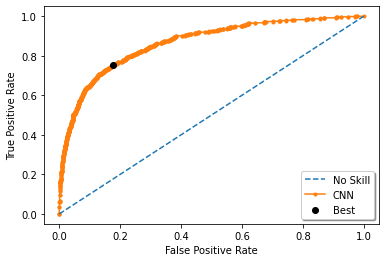

In [22]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# roc curve for logistic regression model with optimal threshold
from numpy import sqrt
from numpy import argmax

# calculate scores
cnn_auc = roc_auc_score(Y_total, Y_PRED_total)
# summarize scores
print('ROC AUC=%.3f' % (cnn_auc))
# calculate roc curves
cnn_fpr, cnn_tpr, thresholds = roc_curve(Y_total, Y_PRED_total)

# plot the roc curve for the model
pyplot.plot(cnn_fpr, cnn_tpr, marker='.', label='CNN')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

gmeans = sqrt(cnn_tpr * (1-cnn_fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('ROC AUC=%.3f' % (cnn_auc))

print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(cnn_fpr, cnn_tpr, marker='.', label='CNN', zorder=1)
pyplot.scatter(cnn_fpr[ix], cnn_tpr[ix], marker='o', color='black', label='Best', zorder=2)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
#pyplot.legend()
pyplot.legend(loc='lower right', fancybox=True, shadow=True)
# show the plot
pyplot.show()

In [14]:
from sklearn.metrics import cohen_kappa_score
print(Y_total)
print(Y_PRED_total)

# acurácia balenceada máxima:
#threshold = 0.085811

# acurácia máxima
threshold_selected = 0.140399
Y_PRED_TH = []

for knee in Y_PRED_total:
  if knee < threshold_selected:
    Y_PRED_TH.append(0)
  else:
    Y_PRED_TH.append(1)

print(Y_PRED_TH)

kappa = cohen_kappa_score(Y_total, Y_PRED_TH)

print(f"Kappa: {kappa}")

[0 0 1 ... 0 0 0]
[0.05690775 0.01140862 0.01040068 ... 0.49720883 0.01303535 0.1324791 ]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 

In [ ]:
def filenames(self, indices=[], basename=False):
        if indices: 
            # grab specific indices
            if basename:
                return [os.path.basename(self.imgs[i][0]) for i in indices]
            else:
                return [self.imgs[i][0] for i in indices]
        else:
            if basename:
                return [os.path.basename(x[0]) for x in self.imgs]
            else:
                return [x[0] for x in self.imgs]

dataset = datasets.ImageFolder(f'/content/drive/MyDrive/CNN_Knee/padrao_ouro_pr/Stratified_{N_FOLDS}/{FOLD}/test')

dataset.imgsdef filenames(self, indices=[], basename=False):
        if indices: 
            # grab specific indices
            if basename:
                return [os.path.basename(self.imgs[i][0]) for i in indices]
            else:
                return [self.imgs[i][0] for i in indices]
        else:
            if basename:
                return [os.path.basename(x[0]) for x in self.imgs]
            else:
                return [x[0] for x in self.imgs]

dataset = datasets.ImageFolder(f'/content/drive/MyDrive/CNN_Knee/padrao_ouro_pr/Stratified_{N_FOLDS}/{FOLD}/test')

dataset.imgs

In [ ]:
imgs_pred = []
for i, img_tuple in enumerate(dataset.imgs):
  img_filename = img_tuple[0].split('/')[-1].split('.')[0]
  imgs_pred.append((img_filename, Y_PRED_1_TH[i]))
print(imgs_pred[:5])
print(len(imgs_pred))

print(len(Y1))
labels_conf = []
for i, img_tuple in enumerate(dataset.imgs):
  img_label = img_tuple[1]
  labels_conf.append((img_label, Y1[i]))
print(labels_conf[:10])
print(len(labels_conf))
for i in range(len(labels_conf)):
    if labels_conf[i][0] != labels_conf[i][1]:
      print(f"Erro em i: {[i]} - {labels_conf[i]}")

In [ ]:
import csv  

header = ('filename', 'predicted')
with open(f'/content/drive/MyDrive/CNN_Knee/file_predicted{FOLD}.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for img_pred in imgs_pred:
      writer.writerow(img_pred)

In [27]:
df_metrics_total = metrics(Y_PRED_total, Y_total, thresholds=np.linspace(0.01, 0.9, 200))

In [28]:
df_metrics_total['F2'] = 5*df_metrics_total['Precision']*df_metrics_total['Sensitivity']/\
(4*df_metrics_total['Precision']+df_metrics_total['Sensitivity'])

In [29]:
df_metrics_total['WBA'] =  (2*df_metrics_total['Sensitivity']+df_metrics_total['Specificity'])/3


In [30]:
df_metrics_total.loc[df_metrics_total['WBA']==max(df_metrics_total['WBA'])]

,Threshold,Sensitivity,Specificity,Accuracy,Balanced Accuracy,Precision,F1,F2,WBA
7,0.041307,0.899054,0.616722,0.649469,0.757888,0.235343,0.373037,0.574829,0.804943


In [31]:
#Ponto maximo de F1
df_metrics_total.loc[df_metrics_total['F1']==max(df_metrics_total['F1'])]

,Threshold,Sensitivity,Specificity,Accuracy,Balanced Accuracy,Precision,F1,F2,WBA
68,0.314121,0.635647,0.913079,0.8809,0.774363,0.489672,0.553191,0.599881,0.728124


In [32]:
#Ponto maximo de F2
df_metrics_total.loc[df_metrics_total['F2']==max(df_metrics_total['F2'])]

,Threshold,Sensitivity,Specificity,Accuracy,Balanced Accuracy,Precision,F1,F2,WBA
44,0.206784,0.705047,0.87024,0.851079,0.787644,0.416201,0.523419,0.619114,0.760112


In [33]:
#Ponto maximo de Balanced Accuracy
df_metrics_total.loc[df_metrics_total['Balanced Accuracy']==max(df_metrics_total['Balanced Accuracy'])]

,Threshold,Sensitivity,Specificity,Accuracy,Balanced Accuracy,Precision,F1,F2,WBA
29,0.139698,0.755521,0.821813,0.814124,0.788667,0.357463,0.485309,0.617905,0.777618


In [34]:
#Maiores sensibilidades, mantendo Spec > 0.4
df_metrics_total.loc[(df_metrics_total['Sensitivity']>0.9) & (df_metrics_total['Specificity']>0.4)]

,Threshold,Sensitivity,Specificity,Accuracy,Balanced Accuracy,Precision,F1,F2,WBA
2,0.018945,0.938486,0.445364,0.502561,0.691925,0.181679,0.304426,0.511960,0.774112
3,0.023417,0.925868,0.495447,0.545371,0.710657,0.194050,0.320853,0.527783,0.782394
4,0.027889,0.919558,0.534561,0.579217,0.727060,0.205862,0.336411,0.543033,0.791226
5,0.032362,0.910095,0.567467,0.607208,0.738781,0.216348,0.349591,0.554488,0.795885
6,0.036834,0.902208,0.591887,0.627881,0.747048,0.224843,0.359975,0.562992,0.798768


In [35]:
#Maior acuracia
df_metrics_total.loc[df_metrics_total['Accuracy']==max(df_metrics_total['Accuracy'])]

,Threshold,Sensitivity,Specificity,Accuracy,Balanced Accuracy,Precision,F1,F2,WBA
157,0.712161,0.362776,0.978270,0.906879,0.670523,0.686567,0.474716,0.400557,0.567941
173,0.783719,0.313880,0.984685,0.906879,0.649283,0.728938,0.438809,0.354219,0.537482


In [36]:
#Maior especificidade
df_metrics_total.loc[df_metrics_total['Specificity']==max(df_metrics_total['Specificity'])]

,Threshold,Sensitivity,Specificity,Accuracy,Balanced Accuracy,Precision,F1,F2,WBA
199,0.9,0.20347,0.993584,0.901939,0.598527,0.80625,0.324937,0.239243,0.466842
